In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from sklearn.preprocessing import StandardScaler, LabelEncoder,MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier

In [ ]:

# Load training data
train_df = pd.read_csv("KDDTrain+.txt", header=None)
print("Training data shape:", train_df.shape)

# Define column names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'label', 'score'
]
train_df.columns = columns

# Encode categorical features
categorical_columns = ['protocol_type', 'service', 'flag']
encoders = {}
for col in categorical_columns:
    encoder = LabelEncoder()
    train_df[col] = encoder.fit_transform(train_df[col])
    encoders[col] = encoder

# Convert labels to binary (1 = anomaly, 0 = normal)
y_train = train_df['label'].apply(lambda x: 1 if x != 'normal' else 0)

# Drop non-feature columns
X_train = train_df.drop(columns=['label', 'score'])

# Scale features
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)

# Reshape data for LSTM
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))  # (samples, timesteps=1, features)


Training data shape: (125973, 43)


In [ ]:
# Define the BiLSTM model
model = Sequential([
    Bidirectional(LSTM(256, return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
     Bidirectional(LSTM(128, return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(64, return_sequences=True, activation='relu'), input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    Bidirectional(LSTM(32, activation='relu')),
    Dropout(0.2),
    Dense(64, activation='relu'),
     Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


print(model.summary())


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 1, 512)              │         610,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1, 512)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 1, 256)              │         656,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1, 256)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 1, 128)              │         164,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 1, 128)              │          98,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_4 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,577,857 (6.02 MB)

 Trainable params: 1,577,857 (6.02 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=20, validation_split=0.2, verbose=1)


Epoch 1/50
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 34s 7ms/step - accuracy: 0.9411 - loss: 0.1303 - val_accuracy: 0.9733 - val_loss: 0.0578
Epoch 2/50
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 29s 4ms/step - accuracy: 0.9834 - loss: 0.0443 - val_accuracy: 0.9882 - val_loss: 0.0335
Epoch 3/50
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9878 - loss: 0.0330 - val_accuracy: 0.9913 - val_loss: 0.0246
Epoch 4/50
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9900 - loss: 0.0280 - val_accuracy: 0.9925 - val_loss: 0.0217
Epoch 5/50
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9908 - loss: 0.0262 - val_accuracy: 0.9934 - val_loss: 0.0206
Epoch 6/50
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - accuracy: 0.9911 - loss: 0.0260 - val_accuracy: 0.9930 - val_loss: 0.0232
Epoch 7/50
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 22s 4ms/step - accuracy: 0.9921 - loss: 0.0234 - val_accuracy: 0.9931 - val_loss: 0.0224
Epoch 8/50
5039/5039 ━━━━━━━━━━━━━━━━━━━━ 40s 4ms/step - accuracy: 0.9924 - loss: 0

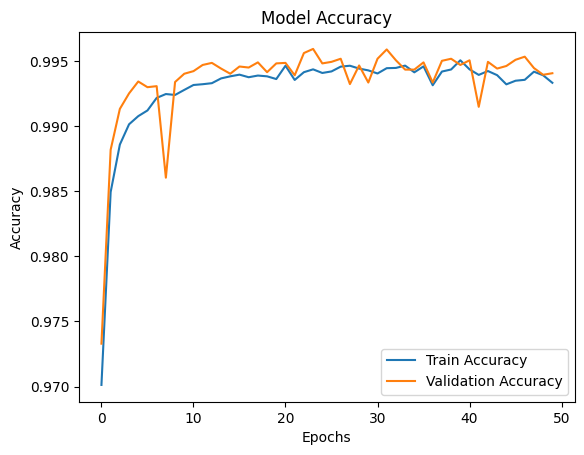

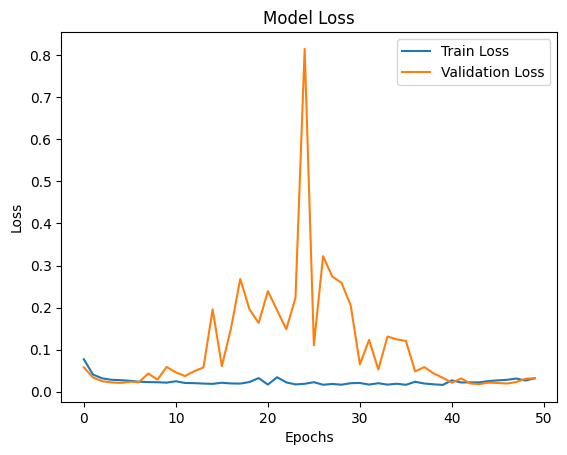

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
# Save the model
model.save("bilstm_model.h5")

# Reload the model
loaded_model = tf.keras.models.load_model("bilstm_model.h5")


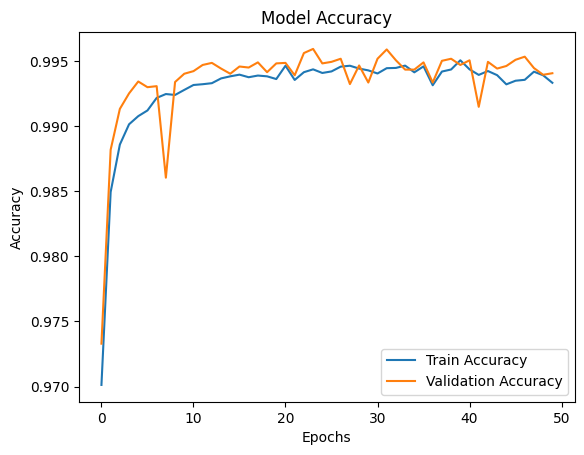

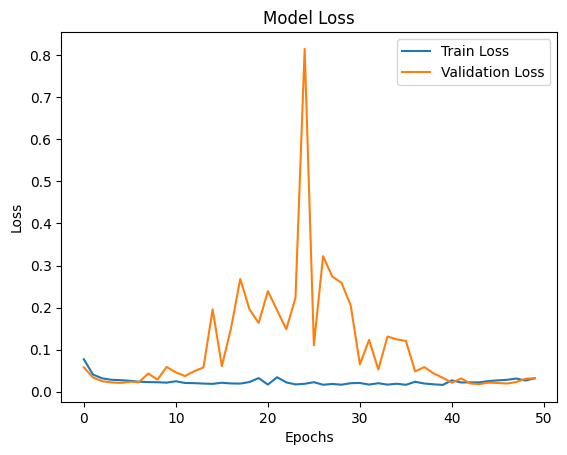

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')
plt.show()


In [ ]:
# Load testing data
test_df = pd.read_csv("KDDTest+.txt", header=None)
print("Testing data shape:", test_df.shape)

# Assign column names to match the training dataset
test_df.columns = columns

# Encode categorical features using the same encoders used for training
for col in categorical_columns:
    test_df[col] = encoders[col].transform(test_df[col])

# Convert labels to binary (1 = anomaly, 0 = normal)
y_test = test_df['label'].apply(lambda x: 1 if x != 'normal' else 0)

# Drop non-feature columns
X_test = test_df.drop(columns=['label', 'score'])

# Scale features using the same scaler used for training
X_test = scaler.transform(X_test)

# Reshape data for LSTM
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))  # (samples, timesteps=1, features)


Testing data shape: (22544, 43)


In [ ]:
# Evaluate the model on the testing dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8130 - loss: 2.2541
Test Loss: 2.3862218856811523
Test Accuracy: 0.807620644569397


705/705 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.97      0.81      9711
           1       0.97      0.68      0.80     12833

    accuracy                           0.81     22544
   macro avg       0.83      0.83      0.81     22544
weighted avg       0.85      0.81      0.81     22544


Confusion Matrix:
[[9445  266]
 [4071 8762]]


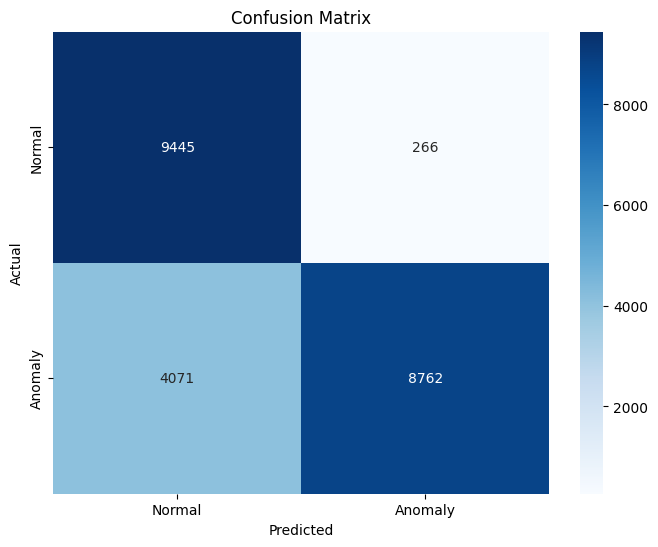

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix,precision_score,recall_score,f1_score,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Make predictions on the test dataset
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Classification metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(conf_matrix)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Anomaly'], yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Print metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8076206529453513
Precision: 0.9705361098803722
Recall: 0.6827709810644432
F1 Score: 0.8016101733680985


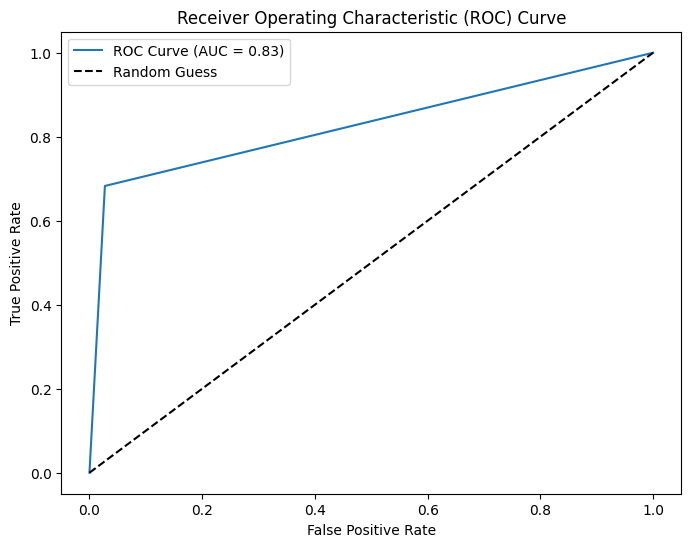

In [ ]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
